# Analysis of experiments
## Homophily network
### Gradual introduction of True Price products

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import cProfile
import pstats
import mesa
pd.set_option('display.max_colwidth', 10000)
import joblib
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_6592/2217476338.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from experiments_model_copy import ConsumatModel

In [3]:

base_config = {
    'TP_percentage': 0.5,
    'tp_introduction_rate': 0.1,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget'],
    'seed': 42,  
    'alpha': 10.0,  
    'beta': 0.5,  
    'homophily_attribute': 'budget'  
}


# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


## Network topology

### Watts-Strogatz Network
- **Type:** Small-world network
- **Known For:** High clustering coefficient and short average path lengths, which mimic many real-world social networks.
- **Formation:** Starts with a ring of `n` nodes each connected to `k` nearest neighbors. Rewires each edge with probability `p` to a randomly chosen node.
- **Key Parameters:**
  - `n`: Number of nodes
  - `k`: Number of nearest neighbors in the initial ring topology
  - `p`: Probability of rewiring each edge

### Barabasi-Albert Network
- **Type:** Scale-free network
- **Known For:** Its degree distribution follows a power law, which is typical for many large networks such as the internet, citation networks, and some social networks.
- **Formation:** Begins with a small number of nodes and adds new nodes one at a time. Each new node is connected to `k` existing nodes with a probability that depends on the number of links that the existing nodes already have.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges to attach from a new node to existing nodes

### Random Regular Network
- **Type:** Regular graph
- **Known For:** Every node has the same number of connections. This uniformity can represent idealized conditions in network modeling.
- **Formation:** Constructed by connecting each node with `d` neighbors chosen at random, ensuring each has the same degree, while avoiding self-loops and duplicate edges.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `d`: Degree of each node

### Holme-Kim Network
- **Type:** Small-world network with scale-free properties
- **Known For:** Combines high clustering and short path lengths (like Watts-Strogatz) with a degree distribution that follows a power law (like Barabasi-Albert).
- **Formation:** Starts like the Barabasi-Albert model by adding one node at a time, connecting to `m` existing nodes based on their degree. After each edge creation, with probability `p` adds an additional edge forming a triangle.
- **Key Parameters:**
  - `n`: Total number of nodes
  - `m`: Number of edges each new node will attempt to make
  - `p`: Triad formation probability



Running simulations for Watts-Strogatz network...


Simulation Progress: 100%|██████████| 10/10 [00:32<00:00,  3.27s/it]


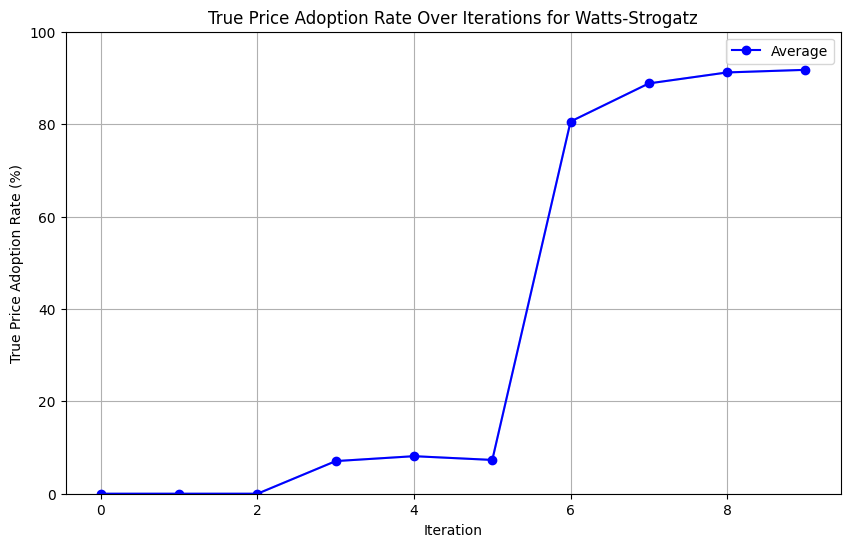

Running simulations for Barabasi-Albert network...


Simulation Progress: 100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


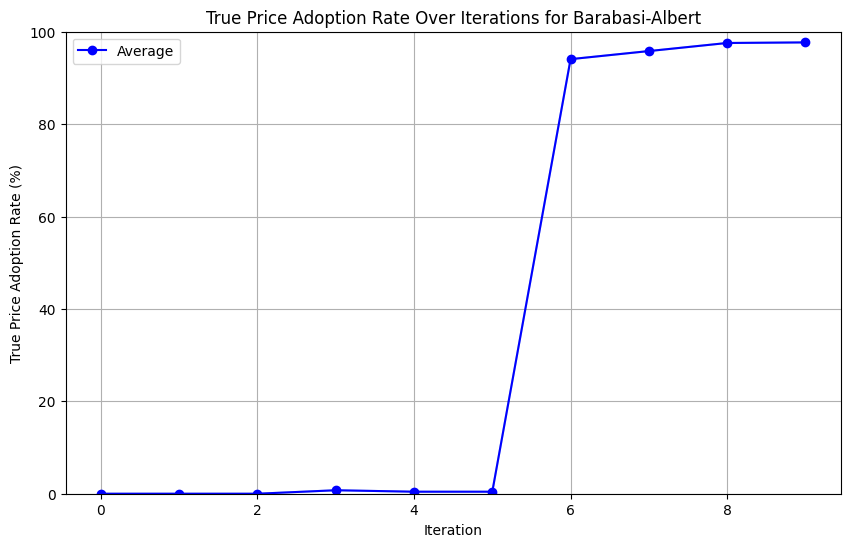

Running simulations for Random Regular network...


Simulation Progress: 100%|██████████| 10/10 [00:29<00:00,  2.91s/it]


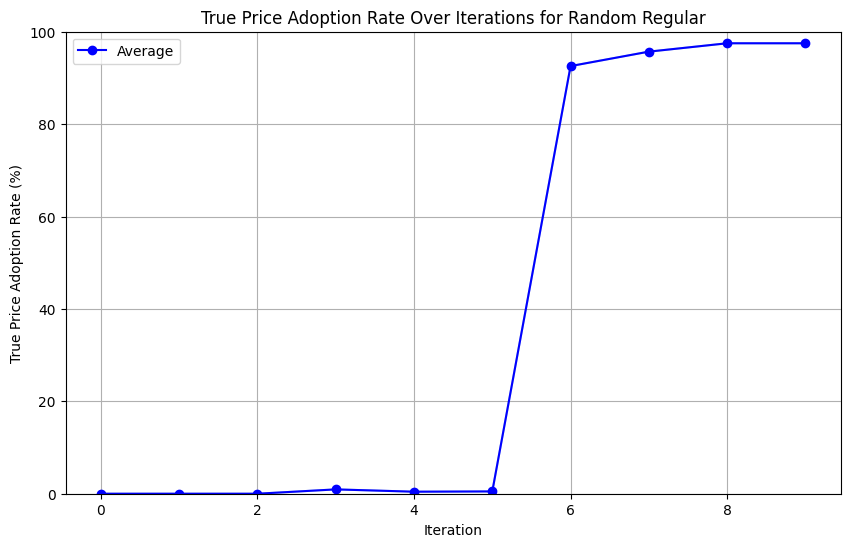

Running simulations for Holme-Kim network...


Simulation Progress: 100%|██████████| 10/10 [00:32<00:00,  3.30s/it]


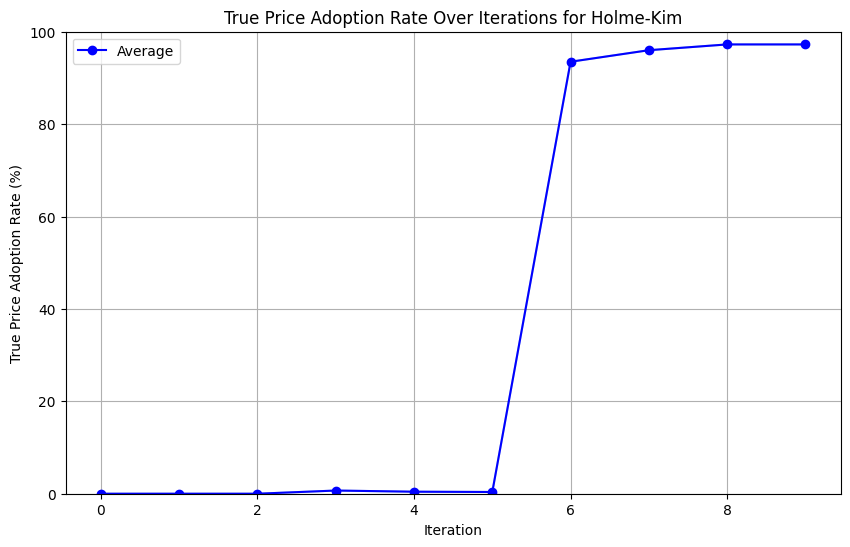

In [4]:
def run_simulation(model, num_steps):
    adoption_rates = []

    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)

    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates

    return model_data, agent_data

def run_all_simulations(configurations, num_steps, num_simulations):
    results = {}
    for config_name, config in configurations.items():
        print(f"Running simulations for {config_name} network...")

        all_simulation_data = []
        
        for simulation in range(num_simulations):
            # Initialize the model with the current configuration
            model = ConsumatModel(config)
            
            model_data, agent_data = run_simulation(model, num_steps)
            all_simulation_data.append(model_data)

        aggregated_data = pd.concat(all_simulation_data).groupby(level=0).mean()

        results[config_name] = aggregated_data

        plt.figure(figsize=(10, 6))
        for sim_data in all_simulation_data:
            plt.plot(sim_data['Adoption Rates'], alpha=0.3)  
        plt.plot(aggregated_data['Adoption Rates'], marker='o', color='b', label='Average')
        plt.title(f'True Price Adoption Rate Over Iterations for {config_name}')
        plt.xlabel('Iteration')
        plt.ylim(0,100)
        plt.ylabel('True Price Adoption Rate (%)')
        plt.grid(True)
        plt.legend()
        plt.show()

    return results

def generate_decision_modes_count(agent_data):
    decision_modes_count = agent_data.groupby(['Step'])[['Repeat', 'Imitate', 'Deliberate', 'Social_Compare']].sum()
    return decision_modes_count

network_configurations = {
    'Watts-Strogatz': watts_strogatz_config,
    'Barabasi-Albert': barabasi_albert_config,
    'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

num_simulations = 1
num_steps = 10

results = run_all_simulations(network_configurations, num_steps, num_simulations)



### Multiple runs of the same model:

Running simulations for Watts-Strogatz network...


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.19s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.19s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.18s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.18s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.18s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.20s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.20s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.23s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.31s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.28s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.20s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.20s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.19s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.19s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.19s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.18s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.18s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.18s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.18s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.18s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.18s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.18s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.18s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.18s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.18s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.18s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.18s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.18s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.17s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.17s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.19s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.19s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.19s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.19s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.18s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.21s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.20s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.18s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.18s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.19s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.19s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.20s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.20s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.19s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.19s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:15,  3.20s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:12<00:12,  3.19s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:15<00:09,  3.19s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.19s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.20s/it]

Time step 7: 10 True Price products available.


Simulation Progress: 100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


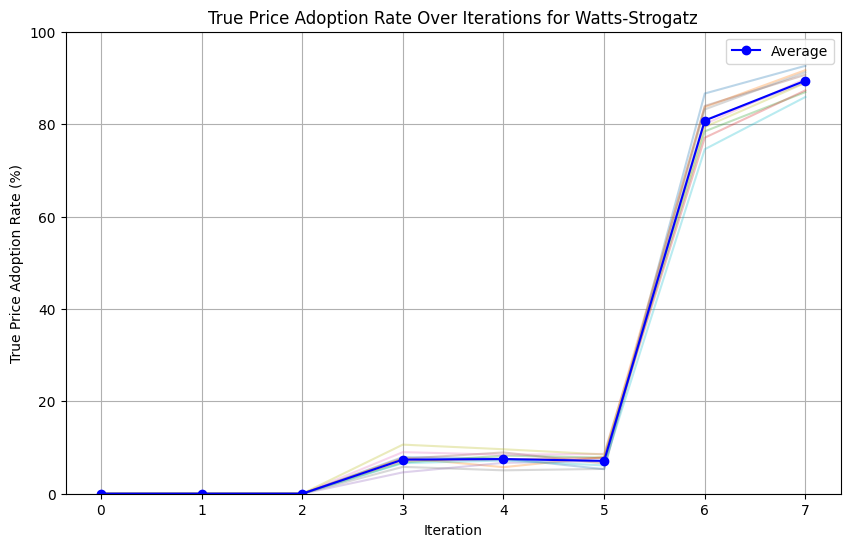

Running simulations for Barabasi-Albert network...


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.34s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.33s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.33s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.33s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.34s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.35s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.34s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:10,  3.34s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:20<00:06,  3.34s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.35s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.34s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.33s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:10,  3.34s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:20<00:06,  3.34s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.34s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.34s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.34s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.33s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.32s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.33s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.33s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.32s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.32s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.32s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.33s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.31s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.31s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.31s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.30s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.31s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.34s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.34s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:10,  3.34s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:20<00:06,  3.34s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.34s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.33s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.32s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.32s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.32s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.33s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.33s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.33s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.33s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.33s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.33s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:16,  3.34s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.34s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:10,  3.34s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:20<00:06,  3.34s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.35s/it]

Time step 7: 10 True Price products available.


Simulation Progress: 100%|██████████| 8/8 [00:26<00:00,  3.34s/it]


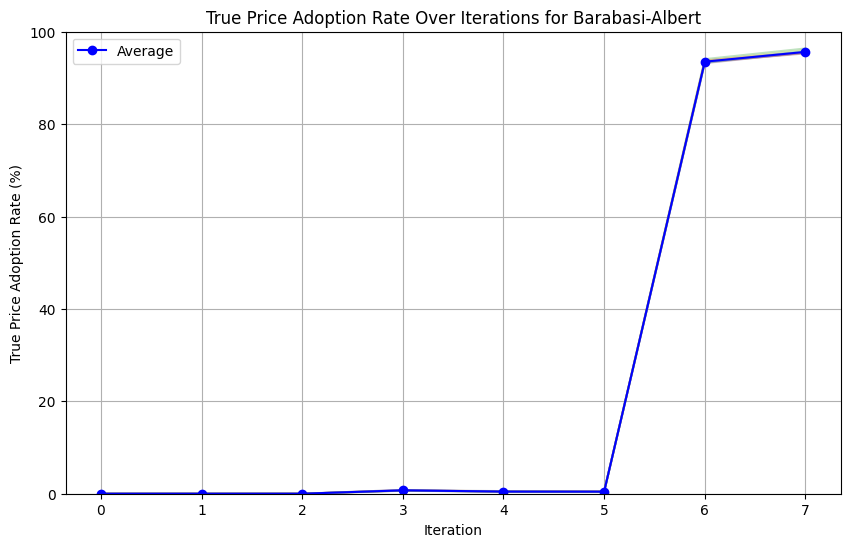

Running simulations for Random Regular network...


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.92s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.93s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.92s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.92s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.93s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.93s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.93s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.92s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.92s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.90s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.92s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.92s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.92s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.92s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.93s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.91s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.91s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.90s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.90s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.92s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.93s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.93s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.92s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.92s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.93s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.95s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.94s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.94s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.94s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.94s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.90s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.90s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.91s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.90s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.91s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.94s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.94s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.93s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.93s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.95s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.91s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.90s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.90s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.90s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.90s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:08<00:14,  2.92s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:11<00:11,  2.92s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:14<00:08,  2.91s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:17<00:05,  2.91s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:20<00:02,  2.92s/it]

Time step 7: 10 True Price products available.


Simulation Progress: 100%|██████████| 8/8 [00:23<00:00,  2.92s/it]


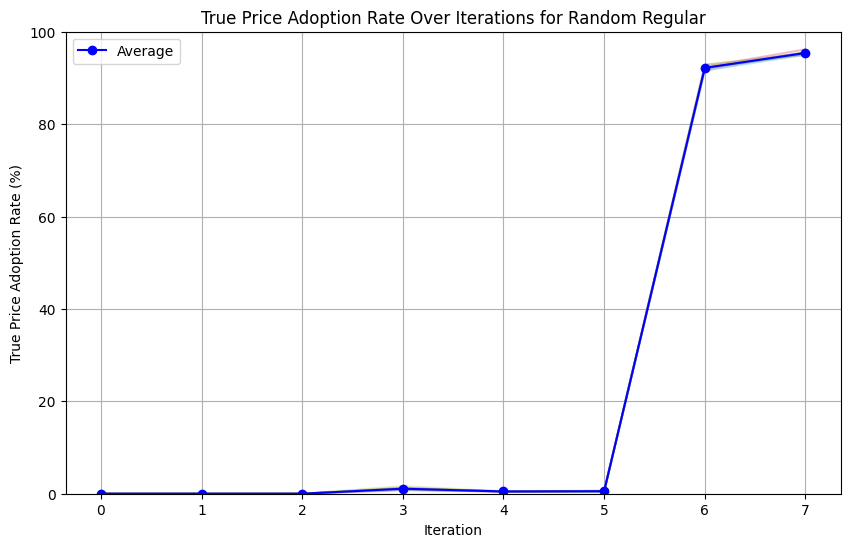

Running simulations for Holme-Kim network...


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.28s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.28s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.28s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.28s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.29s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.28s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.28s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.27s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.28s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.28s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.28s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.27s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.27s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.27s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.28s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.27s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.26s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.27s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.27s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.27s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.30s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.29s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.29s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.29s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.30s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:10<00:17,  3.42s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.38s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:17<00:10,  3.35s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:20<00:06,  3.32s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.32s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.28s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.27s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.27s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.27s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.28s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.29s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.29s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.28s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.28s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:23<00:03,  3.29s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.27s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.27s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.27s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.27s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.28s/it]

Time step 7: 10 True Price products available.


Simulation Progress:  38%|███▊      | 3/8 [00:09<00:16,  3.29s/it]

Time step 3: 2 True Price products available.


Simulation Progress:  50%|█████     | 4/8 [00:13<00:13,  3.28s/it]

Time step 4: 4 True Price products available.


Simulation Progress:  62%|██████▎   | 5/8 [00:16<00:09,  3.27s/it]

Time step 5: 6 True Price products available.


Simulation Progress:  75%|███████▌  | 6/8 [00:19<00:06,  3.27s/it]

Time step 6: 8 True Price products available.


Simulation Progress:  88%|████████▊ | 7/8 [00:22<00:03,  3.28s/it]

Time step 7: 10 True Price products available.


Simulation Progress: 100%|██████████| 8/8 [00:26<00:00,  3.28s/it]


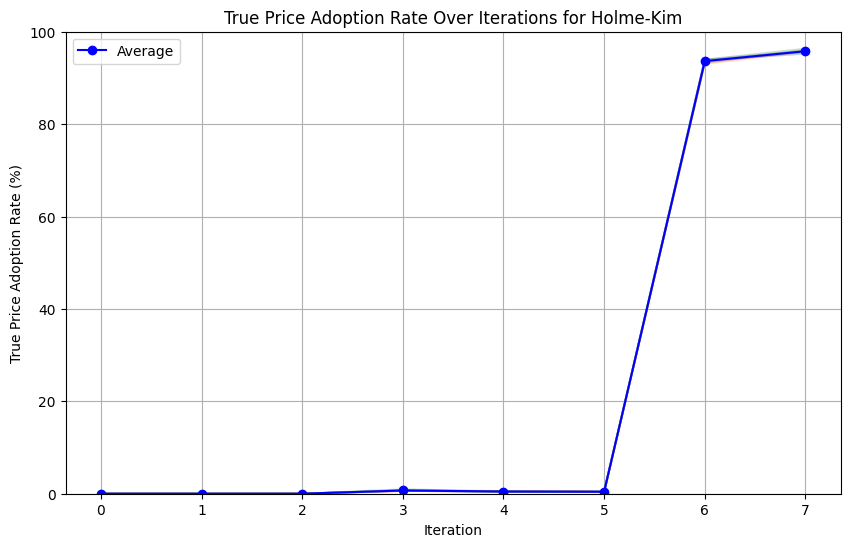

In [8]:
num_simulations = 10
num_steps = 8

results = run_all_simulations(network_configurations, num_steps, num_simulations)

## Global Sensitivity Analysis

Sobol indices

Saltelli sampling

Pick key parameters (e.g. alpha, beta, rewiring probability) and key measures (true price adoption rate...)

### Sensitivity Analysis

In [12]:
from SALib.sample import saltelli
from SALib.analyze import sobol
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

base_config = {
    'TP_percentage': 0.7,
    'tp_introduction_rate': 0.1,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42  
}

# Configuration for Watts-Strogatz network
watts_strogatz_config = base_config.copy()
watts_strogatz_config.update({
    'network_type': 'watts_strogatz',
    'network_params': {
        'n': 1600,
        'k': 8,
        'p': 0.3
    }
})


# Configuration for Barabasi-Albert network
barabasi_albert_config = base_config.copy()
barabasi_albert_config.update({
    'network_type': 'barabasi_albert',
    'network_params': {
        'n': 1600,
        'm': 8
    }
})

# Configuration for Random Regular network
random_regular_config = base_config.copy()
random_regular_config.update({
    'network_type': 'random_regular',
    'network_params': {
        'n': 1600,
        'd': 8
    }
})

# Configuration for Holme-Kim network
holme_kim_config = base_config.copy()
holme_kim_config.update({
    'network_type': 'holme_kim',
    'network_params': {
        'n': 1600,
        'm': 8,
        'p': 0.3
    }
})


network_configs = {
    #'Watts-Strogatz': watts_strogatz_config,
    #'Barabasi-Albert': barabasi_albert_config,
    #'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

network_configurations = {
    #'Watts-Strogatz': watts_strogatz_config,
    #'Barabasi-Albert': barabasi_albert_config,
    #'Random Regular': random_regular_config,
    'Holme-Kim': holme_kim_config
}

network_problems = {
    'Watts-Strogatz': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon', 'min_increase_percentage','max_increase_percentage', 'k', 'p', 'tp_introduction_rate'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1], [1,10], [11,20], [2, 10], [0, 1], [0,1]] 
    },
    'Barabasi-Albert': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold','epsilon','min_increase_percentage', 'max_increase_percentage', 'm', 'tp_introduction_rate'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0,1]]  
    },
    'Random Regular': {
        'num_vars': 8,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','d', 'tp_introduction_rate'],
        'bounds': [[0, 1], [0, 1], [0, 1], [0,1],[1,10], [11,20],[2, 10], [0,1]]  
    },
    'Holme-Kim': {
        'num_vars': 9,
        'names': ['TP_percentage', 'satisfaction_threshold', 'uncertainty_threshold', 'epsilon','min_increase_percentage','max_increase_percentage','m', 'p', 'tp_introduction_rate'],
        'bounds': [[0, 1], [0, 1], [0, 1],[0,1], [1,10], [11,20],[2, 10], [0, 1], [0,1]] 
    }
}

In [13]:
num_samples = 256

samples = {}
for network_name, problem in network_problems.items():
    samples[network_name] = saltelli.sample(problem, num_samples)


/var/folders/53/cl5y6r2x7n5_942j6h59yyh00000gn/T/ipykernel_6592/3049819496.py:7: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  samples[network_name] = saltelli.sample(problem, num_samples)


In [14]:
from joblib import Parallel, delayed
import numpy as np
import pandas as pd
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
import json

def collect_simulation_data(model, num_steps):
    collected_data = {
        'Step': [],
        'Adoption Rate': [],
        'Avg_F_Satisfaction': [],
        'Avg_S_Satisfaction': [],
        'Avg_P_Satisfaction': [],
        'Avg_F_Uncertainty': [],
        'Avg_S_Uncertainty': [],
        'Avg_P_Uncertainty': []
    }

    for step in range(num_steps):
        model.step()
        collected_data['Step'].append(step)
        collected_data['Adoption Rate'].append(model.calculate_true_price_adoption_rate())
        collected_data['Avg_F_Satisfaction'].append(np.mean([agent.F_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_S_Satisfaction'].append(np.mean([agent.S_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_P_Satisfaction'].append(np.mean([agent.P_satisfaction for agent in model.schedule.agents]))
        collected_data['Avg_F_Uncertainty'].append(np.mean([agent.F_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_S_Uncertainty'].append(np.mean([agent.S_uncertainty for agent in model.schedule.agents]))
        collected_data['Avg_P_Uncertainty'].append(np.mean([agent.P_uncertainty for agent in model.schedule.agents]))

    model_data = pd.DataFrame(collected_data)
    return model_data

def run_single_simulation(params, config, network_name, num_steps):
    config = config.copy()
    config['TP_percentage'] = params[0]
    config['satisfaction_threshold'] = params[1]
    config['uncertainty_threshold'] = params[2]
    config['epsilon'] = params[3]
    config['min_increase_percentage'] = params[4]
    config['max_increase_percentage'] = params[5]
    config['tp_introduction_rate'] = params[-1]

    if network_name == 'Watts-Strogatz':
        config['network_params']['k'] = int(params[6])
        config['network_params']['p'] = params[7]
    elif network_name == 'Barabasi-Albert':
        config['network_params']['m'] = int(params[6])
    elif network_name == 'Random Regular':
        config['network_params']['d'] = int(params[6])
    elif network_name == 'Holme-Kim':
        config['network_params']['m'] = int(params[6])
        config['network_params']['p'] = params[7]

    model = ConsumatModel(config)
    model_data = collect_simulation_data(model, num_steps)
    final_step_data = model_data.iloc[-1]

    return [
        final_step_data['Adoption Rate'],
        final_step_data['Avg_F_Satisfaction'],
        final_step_data['Avg_S_Satisfaction'],
        final_step_data['Avg_P_Satisfaction'],
        final_step_data['Avg_F_Uncertainty'],
        final_step_data['Avg_S_Uncertainty'],
        final_step_data['Avg_P_Uncertainty']
    ]

def run_gsa_simulation_parallel(network_name, config, samples, num_steps, n_jobs=-1):
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(run_single_simulation)(params, config, network_name, num_steps)
        for params in tqdm(samples, desc=f'Running simulations for {network_name}')
    )
    return np.array(all_results)

num_steps = 10

for network_name, config in network_configurations.items():
    print(f"Running GSA for {network_name} network...")
    config = base_config.copy()
    config.update(network_configs[network_name])
    all_results = run_gsa_simulation_parallel(network_name, config, samples[network_name], num_steps)
    
    results = {}
    
    for i, output in enumerate(['Adoption Rate', 'Avg_F_Satisfaction', 'Avg_S_Satisfaction', 'Avg_P_Satisfaction', 'Avg_F_Uncertainty', 'Avg_S_Uncertainty', 'Avg_P_Uncertainty']):
        Si = sobol.analyze(network_problems[network_name], all_results[:, i], print_to_console=True)
        results[output] = {
            'S1': Si['S1'].tolist(),
            'ST': Si['ST'].tolist(),
            'S2': Si['S2'].tolist()
        }
        print(f'Sensitivity analysis for {output} ({network_name} network):')
        print(Si)
    
    with open(f'experiments_sensitivity_results_{network_name}.json', 'w') as f:
        json.dump(results, f)


Running GSA for Holme-Kim network...


KeyboardInterrupt: 

Generating phase diagram for Watts-Strogatz network...


Simulation Progress: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]


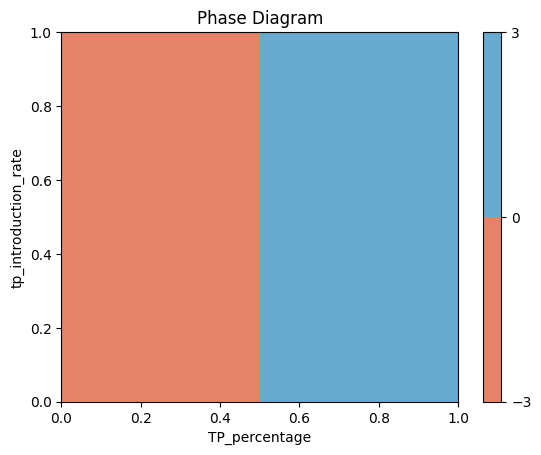

Generating phase diagram for Barabasi-Albert network...


Simulation Progress:  40%|████      | 4/10 [00:08<00:12,  2.05s/it]


KeyboardInterrupt: 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from experiments_model_copy import ConsumatModel

base_config = {
    'TP_percentage': 0.5,
    'tp_introduction_rate': 0.1,
    'satisfaction_threshold': 0.5,
    'uncertainty_threshold': 0.5,
    'product_price_range': (5, 10),
    'min_increase_percentage': 4,
    'max_increase_percentage': 10,
    'num_products': 20,
    'inflation_rate': 3,
    'epsilon': 0.5,
    'comparison_attributes': ['budget', 'preference_sustainability', 'preference_conformity'],
    'seed': 42,  

# Network configurations
network_configs = {
    'Watts-Strogatz': {
        **base_config,
        'network_type': 'watts_strogatz',
        'network_params': {
            'n': 1600,
            'k': 8,
            'p': 0.3
        }
    },
    'Barabasi-Albert': {
        **base_config,
        'network_type': 'barabasi_albert',
        'network_params': {
            'n': 1600,
            'm': 8
        }
    },
    'Random Regular': {
        **base_config,
        'network_type': 'random_regular',
        'network_params': {
            'n': 1600,
            'd': 8
        }
    },
    'Holme-Kim': {
        **base_config,
        'network_type': 'holme_kim',
        'network_params': {
            'n': 1600,
            'm': 8,
            'p': 0.3
        }
    }
}

# Function to run a single simulation and get the adoption rate
def run_simulation(model, num_steps):
    adoption_rates = []
    for _ in tqdm(range(num_steps), desc='Simulation Progress'):
        model.step()
        current_adoption_rate = model.calculate_true_price_adoption_rate()
        adoption_rates.append(current_adoption_rate)
    model_data = model.datacollector.get_model_vars_dataframe()
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data['Adoption Rates'] = adoption_rates
    return model_data, agent_data

# Function to generate data for phase diagrams
def generate_phase_diagram_data(config, param1_range, param2_range, num_steps):
    data = []
    labels = []
    for param1 in param1_range:
        for param2 in param2_range:
            config['TP_percentage'] = param1
            config['tp_introduction_rate'] = param2
            model = ConsumatModel(config)
            adoption_rate = run_simulation(model, num_steps)[0]['Adoption Rates'].iloc[-1]  # Get final adoption rate
            data.append([param1, param2])
            labels.append(adoption_rate > 50)  # Threshold for classification
    return np.array(data), np.array(labels)

# Generate and plot phase diagrams
def plot_phase_diagram(config, param1_range, param2_range, num_steps):
    data, labels = generate_phase_diagram_data(config, param1_range, param2_range, num_steps)
    svm = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    svm.fit(data, labels)
    xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], cmap='RdBu')
    plt.xlabel('TP_percentage')
    plt.ylabel('tp_introduction_rate')
    plt.title('Phase Diagram')
    plt.colorbar()
    plt.show()

param1_range = np.linspace(0, 1, 10)  # TP_percentage
param2_range = np.linspace(0, 1, 10)  # tp_introduction_rate
num_steps = 10

for config_name, config in network_configs.items():
    print(f"Generating phase diagram for {config_name} network...")
    plot_phase_diagram(config, param1_range, param2_range, num_steps)
